<a href="https://colab.research.google.com/github/infomon/understanding_cnn/blob/master/notebooks/Compare_Methods_on_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Compare analyzers on MNIST

This notebook shows how saliency maps are computed for various methods on the MNIST dataset. We will first train a simple 3-layer MLP and then apply different methods. In the end we allow for a qualitive assesment by plotting the analysis as a grid.


## Imports

In [13]:
!pip install -q git+https://github.com/albermax/innvestigate
!git clone https://github.com/infomon/understanding_cnn
import shutil
import os
if not os.path.isfile("utils.py"):
  shutil.move("/content/understanding_cnn/utils/utils.py", "/content")
if not os.path.isfile("utils_mnist.py"):
  shutil.move("/content/understanding_cnn/utils/utils_mnist.py", "/content")
if not os.path.isfile("MNISTcnn.h5"):
  shutil.move("/content/understanding_cnn/models/pretrained_models/cnn_MNIST_model.h5df", "/content")
!rm -r understanding_cnn

Cloning into 'understanding_cnn'...
remote: Enumerating objects: 196, done.
remote: Counting objects: 100% (196/196), done.
remote: Compressing objects: 100% (168/168), done.
remote: Total 196 (delta 90), reused 91 (delta 21), pack-reused 0
Receiving objects: 100% (196/196), 15.61 MiB | 17.03 MiB/s, done.
Resolving deltas: 100% (90/90), done.


In [0]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('ignore')

In [0]:
%matplotlib inline  

import imp
import numpy as np
import os

import keras
import keras.backend
import keras.models
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint

import innvestigate
import innvestigate.utils as iutils

# Use utility libraries to focus on relevant iNNvestigate routines.
eutils = imp.load_source("utils", "utils.py")
mnistutils = imp.load_source("utils_mnist", "utils_mnist.py")

## Data
Load the dataset and keep some images from the test set for the analysis.

In [0]:
# Load data
# returns x_train, y_train, x_test, y_test as numpy.ndarray
data_not_preprocessed = mnistutils.fetch_data()

# Create preprocessing functions
input_range = [-1, 1]
preprocess, revert_preprocessing = mnistutils.create_preprocessing_f(data_not_preprocessed[0], input_range)

# Preprocess data
data = (
    preprocess(data_not_preprocessed[0]), data_not_preprocessed[1],
    preprocess(data_not_preprocessed[2]), data_not_preprocessed[3]
)

num_classes = len(np.unique(data[1]))
label_to_class_name = [str(i) for i in range(num_classes)]

# convert class vectors to binary class matrices
x_train = data[0]
x_test = data[2]
y_train = keras.utils.to_categorical(data[1], num_classes)
y_test = keras.utils.to_categorical(data[3], num_classes)

## Model
The next part trains and evaluates a CNN.

In [24]:
batch_size = 128
epochs = 15
input_shape = (28, 28, 1)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

mcp_save = ModelCheckpoint('cnn_model.hdf5', save_best_only=True, monitor='val_acc', mode='max')

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          callbacks=[mcp_save],
          validation_data=(x_test, y_test))


Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 10s 167us/step - loss: 0.2771 - acc: 0.9169 - val_loss: 0.0556 - val_acc: 0.9825
Epoch 2/15
60000/60000 [==============================] - 9s 144us/step - loss: 0.0974 - acc: 0.9707 - val_loss: 0.0442 - val_acc: 0.9861
Epoch 3/15
60000/60000 [==============================] - 9s 144us/step - loss: 0.0731 - acc: 0.9783 - val_loss: 0.0358 - val_acc: 0.9888
Epoch 4/15
60000/60000 [==============================] - 9s 143us/step - loss: 0.0574 - acc: 0.9823 - val_loss: 0.0349 - val_acc: 0.9896
Epoch 5/15
60000/60000 [==============================] - 9s 144us/step - loss: 0.0504 - acc: 0.9841 - val_loss: 0.0302 - val_acc: 0.9899
Epoch 6/15
60000/60000 [==============================] - 9s 144us/step - loss: 0.0425 - acc: 0.9867 - val_loss: 0.0308 - val_acc: 0.9903
Epoch 7/15
60000/60000 [==============================] - 9s 145us/step - loss: 0.0402 - acc: 0.9873 - val_loss: 0.0269 -

## Analysis

Next, we will set up a list of analysis methods by preparing tuples containing the methods' string identifiers used by `innvestigate.analyzer.create_analyzer(...)`, some optional parameters, a post processing choice for visualizing the computed analysis and a title for the figure to render. Analyzers can be deactivated by simply commenting the corresponding lines, or added by creating a new tuple as below.

For a full list of methods refer to the dictionary `investigate.analyzer.analyzers`

In [0]:
# Scale to [0, 1] range for plotting.
def input_postprocessing(X):
    return revert_preprocessing(X) / 255

noise_scale = (input_range[1]-input_range[0]) * 0.1
ri = input_range[0]  # reference input


# Configure analysis methods and properties
# Configure analysis methods and properties
methods = [
    # NAME                    OPT.PARAMS                POSTPROC FXN               TITLE

    # Function
    ("gradient", {"postprocess": "abs"}, mnistutils.graymap, "Gradient"),  # 0
    ("smoothgrad", {"noise_scale": noise_scale,
                    "postprocess": "square"}, mnistutils.graymap, "SmoothGrad"),  # 1

    # Signal
    ("deconvnet", {}, mnistutils.bk_proj, "Deconvnet"),  # 2
    ("guided_backprop", {}, mnistutils.bk_proj, "Guided Backprop",),  # 3
    ("pattern.net", {"pattern_type": "relu"}, mnistutils.bk_proj, "PatternNet"),  # 4

    # Interaction
    ("pattern.attribution", {"pattern_type": "relu"}, mnistutils.heatmap, "PatternAttribution"),  # 5
    ("deep_taylor.bounded", {"low": input_range[0],
                                 "high": input_range[1]}, mnistutils.heatmap, "DeepTaylor"),  # 6
    ("input_t_gradient", {}, mnistutils.heatmap, "Input * Gradient"),  # 7
    ("integrated_gradients", {"reference_inputs": ri}, mnistutils.heatmap, "Integrated Gradients"),  # 8
    ("lrp.z", {}, mnistutils.heatmap, "LRP-Z"),  # 9
    ("lrp.epsilon", {"epsilon": 1}, mnistutils.heatmap, "LRP-Epsilon"),  # 10
    ("lrp.epsilon_IB", {"epsilon": 1}, mnistutils.heatmap, "LRP-Epsilon"),  # 11
    ("lrp.alpha_1_beta_0", {}, mnistutils.heatmap, "LRP-Alpha1-Beta0"),  # 12
    ("lrp.alpha_1_beta_0_IB", {}, mnistutils.heatmap, "LRP-Alpha1-Beta0 IB"),  # 13
    ("lrp.alpha_2_beta_1", {}, mnistutils.heatmap, "LRP-Alpha2-Beta1"),  # 14
    ("lrp.alpha_2_beta_1_IB", {}, mnistutils.heatmap, "LRP-Alpha2-Beta1 IB"),  # 15
    ]

The main loop below will now instantiate the analyzer objects based on the loaded/trained model and the analyzers' parameterizations above.

In [26]:
# Create model without trailing softmax
model_wo_softmax = iutils.keras.graph.model_wo_softmax(model)

# Create analyzers.
analyzers = []
for method in methods:
    analyzer = innvestigate.create_analyzer(method[0],        # analysis method identifier
                                            model_wo_softmax, # model without softmax output
                                            **method[1])      # optional analysis parameters

    # Some analyzers require training.
    analyzer.fit(data[0], batch_size=256, verbose=1)
    analyzers.append(analyzer)

Epoch 1/1
235/235 [==============================] - 12s 52ms/step - loss: 4.0000 - broadcast_9_loss: 1.0000 - broadcast_10_loss: 1.0000 - broadcast_11_loss: 1.0000 - broadcast_12_loss: 1.0000
Epoch 1/1
235/235 [==============================] - 12s 53ms/step - loss: 4.0000 - broadcast_13_loss: 1.0000 - broadcast_14_loss: 1.0000 - broadcast_15_loss: 1.0000 - broadcast_16_loss: 1.0000


Now we analyze each image with the different analyzers:

In [0]:
%%capture

n = 10
test_images = list(zip(data[2][:n], data[3][:n]))

analysis = np.zeros([len(test_images), len(analyzers), 28, 28, 3])
text = []


for i, (x, y) in enumerate(test_images):
    # Add batch axis.
    x = x[None, :, :, :]
    
    # Predict final activations, probabilites, and label.
    presm = model_wo_softmax.predict_on_batch(x)[0]
    prob = model.predict_on_batch(x)[0]
    y_hat = prob.argmax()
    
    # Save prediction info:
    text.append(("%s" % label_to_class_name[y],    # ground truth label
                 "%.2f" % presm.max(),             # pre-softmax logits
                 "%.2f" % prob.max(),              # probabilistic softmax output  
                 "%s" % label_to_class_name[y_hat] # predicted label
                ))

    for aidx, analyzer in enumerate(analyzers):
        # Analyze.
        a = analyzer.analyze(x)
        
        # Apply common postprocessing, e.g., re-ordering the channels for plotting.
        a = mnistutils.postprocess(a)
        # Apply analysis postprocessing, e.g., creating a heatmap.
        a = methods[aidx][2](a)
        # Store the analysis.
        analysis[i, aidx] = a[0]

Next, we visualize the analysis results:

<Figure size 432x288 with 0 Axes>

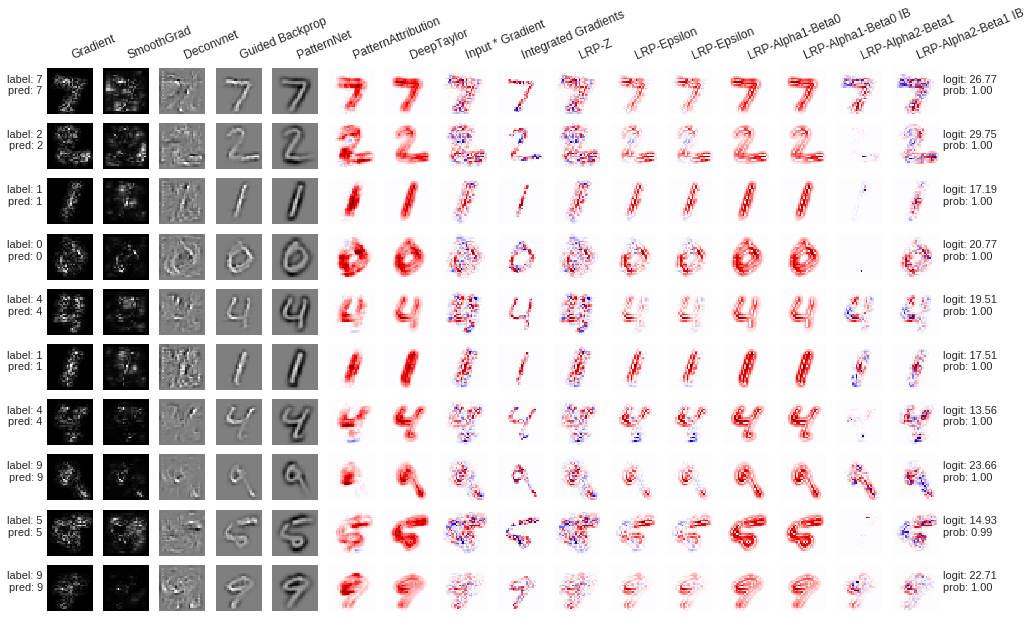

In [28]:
# Prepare the grid as rectengular list
grid = [[analysis[i, j] for j in range(analysis.shape[1])]
        for i in range(analysis.shape[0])]
# Prepare the labels
label, presm, prob, pred = zip(*text)
row_labels_left = [('label: {}'.format(label[i]), 'pred: {}'.format(pred[i])) for i in range(len(label))]
row_labels_right = [('logit: {}'.format(presm[i]), 'prob: {}'.format(prob[i])) for i in range(len(label))]
col_labels = [''.join(method[3]) for method in methods]

# Plot the analysis.
eutils.plot_image_grid(grid, row_labels_left, row_labels_right, col_labels,
                       file_name=os.environ.get("PLOTFILENAME", None))

Each column shows the visualized results for different analyzers and each row shows the analyses w.r.t. to one input sample. To the left of each row, the ground truth label `label` and the predicted label `pred` are show. To the right, the model's probabilistic (softmax) output is shown as `prob` and the logit output just before the terminating softmax layer as `logit`. Note that all analyses have been performed based on the logit output (layer).

This figure shows the analysis w.r.t. to most activated neuron, e.g., *actually predicted* class. To see how to analyze the prediction w.r.t. to other neurons/classes have a look here: [Analyzing different classes with MNIST](mnist_neuron_selection.ipynb)

If you are curious about how *iNNvestigate* performs on ImageNet model, have a look here: [Comparing methods on ImageNet](imagenet_method_comparison.ipynb) and [Comparing networks on ImageNet](imagenet_network_comparison.ipynb)